In [1]:
import sys
import os

sys.path.append(os.path.abspath('root/deepfashion-image-classification/src'))

In [2]:
import timm
import torch
import torch.nn as nn
import torchvision.transforms.v2 as T
from torch.utils.data import DataLoader

import yaml
from tqdm import tqdm
from PIL import Image
from data.v2.dataset import get_dataloaders

import random
import numpy as np
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Load Model

In [3]:
model = timm.create_model('mobilenetv3_large_100.ra_in1k', pretrained=True, num_classes=20)

In [4]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

In [5]:
# for name, param in model.named_parameters():
#     print(name, param.requires_grad)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

classifier.weight
classifier.bias


In [6]:
# unfreeze more layers
for name, param in model.named_parameters():
    if any(x in name for x in ['blocks.6', 'blocks.5']):
        param.requires_grad = True

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

blocks.5.0.conv_pw.weight
blocks.5.0.bn1.weight
blocks.5.0.bn1.bias
blocks.5.0.conv_dw.weight
blocks.5.0.bn2.weight
blocks.5.0.bn2.bias
blocks.5.0.se.conv_reduce.weight
blocks.5.0.se.conv_reduce.bias
blocks.5.0.se.conv_expand.weight
blocks.5.0.se.conv_expand.bias
blocks.5.0.conv_pwl.weight
blocks.5.0.bn3.weight
blocks.5.0.bn3.bias
blocks.5.1.conv_pw.weight
blocks.5.1.bn1.weight
blocks.5.1.bn1.bias
blocks.5.1.conv_dw.weight
blocks.5.1.bn2.weight
blocks.5.1.bn2.bias
blocks.5.1.se.conv_reduce.weight
blocks.5.1.se.conv_reduce.bias
blocks.5.1.se.conv_expand.weight
blocks.5.1.se.conv_expand.bias
blocks.5.1.conv_pwl.weight
blocks.5.1.bn3.weight
blocks.5.1.bn3.bias
blocks.5.2.conv_pw.weight
blocks.5.2.bn1.weight
blocks.5.2.bn1.bias
blocks.5.2.conv_dw.weight
blocks.5.2.bn2.weight
blocks.5.2.bn2.bias
blocks.5.2.se.conv_reduce.weight
blocks.5.2.se.conv_reduce.bias
blocks.5.2.se.conv_expand.weight
blocks.5.2.se.conv_expand.bias
blocks.5.2.conv_pwl.weight
blocks.5.2.bn3.weight
blocks.5.2.bn3.bias
b

# Load Data

In [7]:
processor = model.default_cfg

In [8]:
with open('root/deepfashion-image-classification/configs/mobilenet.yaml') as f:
    config = yaml.safe_load(f)
train_loader, val_loader = get_dataloaders(config, processor, train=True)

# Train

In [9]:
config['train']['learning_rate']

0.0001

In [10]:
epochs = config['train']['epochs']
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=config['train']['learning_rate'], weight_decay=config['train']['weight_decay'])
optimizer = torch.optim.AdamW([
    {"params": model.classifier.parameters(), "lr": 1e-4},
    {"params": [p for n, p in model.named_parameters() if p.requires_grad and 'classifier' not in n], "lr": 3e-5}
], weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

train_losses = []
val_losses = []

for e in range(epochs):
    train_epoch_loss = 0
    val_epoch_loss = 0

    for X_train, y_train in tqdm(train_loader, desc=f'Training Epoch {e}', leave=False):
        X_train, y_train = X_train.to(device), y_train.to(device)
        train_preds = model(X_train)
        loss_train = criterion(train_preds, y_train)
        train_epoch_loss += loss_train.item()

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

    correct = 0
    total = 0
    with torch.no_grad():
        for X_val, y_val in tqdm(val_loader, desc=f'Validating Epoch {e}', leave=False):
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_preds = model(X_val)
            loss_val = criterion(val_preds, y_val)
            val_epoch_loss += loss_val.item()

            _, preds = torch.max(val_preds, 1)
            correct += (preds == y_val).sum().item()
            total += y_val.size(0)

    train_epoch_loss /= len(train_loader)
    val_epoch_loss /= len(val_loader)
    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)

    print(f"Epoch {e:2} Train loss: {train_epoch_loss:8.6f} Val loss: {val_epoch_loss:8.6f} Val acc: {correct / total:.4f} LR: {scheduler.get_last_lr()}")
    # scheduler.step(val_epoch_loss)
    #  LR: {scheduler.get_last_lr()}
    scheduler.step()

Training Epoch 0:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch  0 Train loss: 3.188890 Val loss: 2.893338 Val acc: 0.1699 LR: [0.0001, 3e-05]


Epoch  1 Train loss: 2.487471 Val loss: 2.522882 Val acc: 0.2731 LR: [9.757729755661011e-05, 2.929031948627973e-05]


Epoch  2 Train loss: 2.158020 Val loss: 2.359806 Val acc: 0.3275 LR: [9.05463412215599e-05, 2.7230746418436738e-05]


Epoch  3 Train loss: 2.001879 Val loss: 2.247545 Val acc: 0.3720 LR: [7.959536998847742e-05, 2.402288615824086e-05]


Epoch  4 Train loss: 1.892978 Val loss: 2.214980 Val acc: 0.3876 LR: [6.57963412215599e-05, 1.9980746418436738e-05]


Epoch  5 Train loss: 1.820852 Val loss: 2.189551 Val acc: 0.3990 LR: [5.05e-05, 1.55e-05]


Epoch  6 Train loss: 1.785806 Val loss: 2.150341 Val acc: 0.4202 LR: [3.5203658778440106e-05, 1.1019253581563265e-05]


Epoch  7 Train loss: 1.748193 Val loss: 2.128470 Val acc: 0.4233 LR: [2.1404630011522586e-05, 6.977113841759141e-06]


Epoch  8 Train loss: 1.734621 Val loss: 2.116103 Val acc: 0.4285 LR: [1.0453658778440109e-05, 3.769253581563264e-06]


Epoch  9 Train loss: 1.729651 Val loss: 2.116397 Val acc: 0.4295 LR: [3.4227024433899e-06, 1.7096805137202739e-06]


Epoch 10 Train loss: 1.679767 Val loss: 2.068814 Val acc: 0.4523 LR: [0.0001, 3e-05]


Epoch 11 Train loss: 1.635126 Val loss: 2.054631 Val acc: 0.4503 LR: [9.939057285945933e-05, 2.98214809386295e-05]


Epoch 12 Train loss: 1.572289 Val loss: 2.027697 Val acc: 0.4684 LR: [9.757729755661011e-05, 2.929031948627973e-05]


Epoch 13 Train loss: 1.523933 Val loss: 1.998274 Val acc: 0.4751 LR: [9.460482294732421e-05, 2.8419594600731333e-05]


Epoch 14 Train loss: 1.485912 Val loss: 2.009000 Val acc: 0.4705 LR: [9.05463412215599e-05, 2.7230746418436738e-05]


Epoch 15 Train loss: 1.450551 Val loss: 2.017660 Val acc: 0.4710 LR: [8.55017856687341e-05, 2.5753048327204938e-05]


Epoch 16 Train loss: 1.405134 Val loss: 1.999801 Val acc: 0.4710 LR: [7.959536998847742e-05, 2.402288615824086e-05]


Epoch 17 Train loss: 1.374758 Val loss: 1.953982 Val acc: 0.4933 LR: [7.297252973710757e-05, 2.208286224622343e-05]


Epoch 18 Train loss: 1.358341 Val loss: 2.005145 Val acc: 0.4756 LR: [6.57963412215599e-05, 1.9980746418436738e-05]


Epoch 19 Train loss: 1.326143 Val loss: 1.950520 Val acc: 0.5041 LR: [5.8243506019491436e-05, 1.776829974308335e-05]


<Axes: >

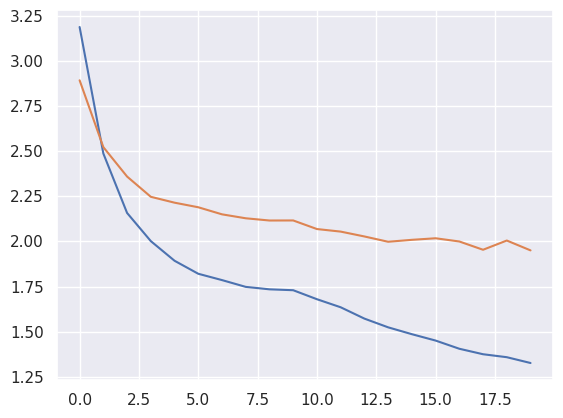

In [13]:
sns.lineplot(train_losses)
sns.lineplot(val_losses)